<a href="https://colab.research.google.com/github/roses-and-thorns/BCS_Introductory_Comp_Neuro/blob/main/Week5/ML_W1D2_Tutorial6_ManasviNidugala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 6: Model Selection: Cross-validation

**Week 1, Day 2: Model Fitting**

**By Neuromatch Academy**

**Content creators**: Pierre-Étienne Fiquet, Anqi Wu, Alex Hyafil with help from Ella Batty

**Content reviewers**: Lina Teichmann, Patrick Mineault, Michael Waskom

**Production editors:** Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

*Estimated timing of tutorial: 25 minutes*

This is Tutorial 6 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of regression models by generalizing to multiple linear regression and polynomial regression (Tutorial 4). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 5) and Cross Validation for model selection (Tutorial 6).

Tutorial objectives:
* Implement cross-validation and use it to compare polynomial regression model

In [7]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "2mkq4"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/2mkq4/


---
# Setup

In [8]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D2_T6"

In [9]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [10]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [11]:
# @title Plotting Functions


def plot_cross_validate_MSE(mse_all):
  """ Plot the MSE values for the K_fold cross validation

  Args:
    mse_all (ndarray): an array of size (number of splits, max_order + 1)
  """
  plt.figure()
  plt.boxplot(mse_all, labels=np.arange(0, max_order + 1))

  plt.xlabel('Polynomial Order')
  plt.ylabel('Validation MSE')
  plt.title(f'Validation MSE over {n_splits} splits of the data')
  plt.show()


def plot_AIC(order_list, AIC_list):
  """ Plot the AIC value for fitted polynomials of various orders

  Args:
    order_list (list): list of fitted polynomial orders
    AIC_list (list): list of AIC values corresponding to each polynomial model on order_list
  """
  plt.bar(order_list, AIC_list)
  plt.ylabel('AIC')
  plt.xlabel('polynomial order')
  plt.title('comparing polynomial fits')
  plt.show()

In [12]:
# @title Helper Functions

def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """

  return np.linalg.inv(x.T @ x) @ x.T @ y


def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression

  Args:
    x (ndarray): input vector of shape (n_samples)
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """

  # Broadcast to shape (n x 1)
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1))

  # Loop through rest of degrees and stack columns
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix


def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys, and np array of theta
  # (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order + 1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hats[order] = this_theta

  return theta_hats


def evaluate_poly_reg(x, y, theta_hats, max_order):
    """ Evaluates MSE of polynomial regression models on data

    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      theta_hat (dict): fitted weights for each polynomial model (dict key is order)
      max_order (scalar): max order of polynomial fit

    Returns
      (ndarray): mean squared error for each order, shape (max_order)
    """

    mse = np.zeros((max_order + 1))
    for order in range(0, max_order + 1):
      X_design = make_design_matrix(x, order)
      y_hat = np.dot(X_design, theta_hats[order])
      residuals = y - y_hat
      mse[order] = np.mean(residuals ** 2)

    return mse

---
# Section 1: Cross-validation



In [13]:
# @title Video 1: Cross-Validation
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'OtKw0rSRxo4'), ('Bilibili', 'BV1mt4y1Q7C4')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [14]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_CrossValidation_Video")

We now have multiple choices for which model to use for a given problem: we could use linear regression, order 2 polynomial regression, order 3 polynomial regression, etc. As we saw in Tutorial 5, different models will have different quality of predictions, both on the training data and on the test data.

A commonly used method for model selection is to ask how well the model predicts new data that it hasn't seen yet. But we don't want to use test data to do this, otherwise that would mean using it during the training process! One approach is to use another kind of held-out data which we call **validation data**: we do not fit the model with this data but we use it to select our best model.

We often have a limited amount of data though (especially in neuroscience), so we do not want to further reduce our potential training data by reassigning some as validation. Luckily, we can use **k-fold cross-validation**! In k-fold cross validation, we divide up the training data into k subsets (that are called *folds*, see diagram below), train our model on the first k-1 folds, and then compute error on the last held-out fold. We can then repeat this process k times, once on each k-1 folds of the data. Each of these k instances (which are called *splits*, see diagram below) excludes a different fold from fitting. We then average the error of each of the k trained models on its held-out subset - this is the final measure of performance which we can use to do model selection.

To make this explicit, let's say we have 1000 samples of training data and choose 4-fold cross-validation. Samples 0 - 250 would be subset 1, samples 250 - 500 subset 2, samples 500 - 750 subset 3, and samples 750-1000 subset 4. First, we train an order 3 polynomial regression on subsets 1, 2, 3 and evaluate on subset 4. Next, we train an order 3 polynomial model on subsets 1, 2, 4 and evaluate on subset 3. We continue until we have 4 instances of a trained order 3 polynomial regression model, each with a different subset as held-out data, and average the held-out error from each instance.

We can now compare the error of different models to pick a model that generalizes well to held-out data. We can choose the measure of prediction quality to report error on the held-out subsets to suit our purposes. We will use MSE here but we could also use log likelihood of the data and so on.

As a final step, it is common to retrain this model on all of the training data (without subset divisions) to get our final model that we will evaluate on test data. This approach allows us to evaluate the quality of predictions on new data without sacrificing any of our precious training data.

Note that the held-out subsets are called either validation or test subsets. There is not a consensus and may depend on the exact use of k-fold cross validation. Sometimes people use k-fold cross validation to choose between different models/parameters to then apply to held-out test data and sometimes people report the averaged error on the held-out subsets as the model performance.   If you are doing the former (using k-fold cross validation for model selection), you must report performance on held-out test data! In this text/code, we will refer to them as validation subsets to differentiate from our completely held-out test data (differing from the video above).


These steps are summarized in this diagram from Scikit-learn (https://scikit-learn.org/stable/modules/cross_validation.html)

![Diagram from Sklearn](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Importantly, we need to be very careful when dividing the data into subsets.  The held-out subset should not be used in any way to fit the model. We should not do any preprocessing (e.g. normalization) before we divide into subsets or the held-out subset could influence the training subsets. A lot of false-positives in cross-validation come from wrongly dividing.

An important consideration in the choice of model selection method are the relevant biases. If we just fit using MSE on training data, we will generally find that fits get better as we add more parameters because the model will overfit the data, as we saw in Tutorial 5. When using cross-validation, the bias is the other way around. Models with more parameters are more affected by variance so cross-validation will generally prefer models with fewer parameters.



We will again simulate some train and test data and fit polynomial regression models


In [15]:
#@title
#@markdown Execute this cell to simulate data and fit polynomial regression models

### Generate training data
np.random.seed(0)
n_train_samples = 50
x_train = np.random.uniform(-2, 2.5, n_train_samples)  # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_train_samples)  # sample from a standard normal distribution
y_train = x_train**2 - x_train - 2 + noise

### Generate testing data
n_test_samples = 20
x_test = np.random.uniform(-3, 3, n_test_samples)  # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_test_samples)  # sample from a standard normal distribution
y_test = x_test**2 - x_test - 2 + noise

### Fit polynomial regression models
max_order = 5
theta_hats = solve_poly_reg(x_train, y_train, max_order)

## Coding Exercise 1: Implement cross-validation

Given our set of models to evaluate (polynomial regression models with orders 0 through 5), we will use cross-validation to determine which model has the best predictions on new data according to MSE.

In this code, we split the data into 10 subsets using `Kfold` (from `sklearn.model_selection`). `KFold` handles cross-validation subset splitting and train/val assignments.  In particular, the `Kfold.split` method returns an iterator which we can loop through. On each loop, this iterator assigns a different subset as validation and returns new training and validation indices with which to split the data.

We will loop through the 10 train/validation splits and fit several different polynomial regression models (with different orders) for each split. You will need to use the `solve_poly_reg` method from Tutorial 4 and `evaluate_poly_reg` from Tutorial 5 (already implemented in this notebook).

We will visualize the validation MSE over 10 splits of the data for each polynomial order using box plots.

In [16]:
help(solve_poly_reg)

Help on function solve_poly_reg in module __main__:

solve_poly_reg(x, y, max_order)
    Fit a polynomial regression model for each order 0 through max_order.
    
    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      max_order (scalar): max order for polynomial fits
    
    Returns:
      dict: fitted weights for each polynomial model (dict key is order)



In [17]:
help(evaluate_poly_reg)

Help on function evaluate_poly_reg in module __main__:

evaluate_poly_reg(x, y, theta_hats, max_order)
    Evaluates MSE of polynomial regression models on data
    
    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      theta_hat (dict): fitted weights for each polynomial model (dict key is order)
      max_order (scalar): max order of polynomial fit
    
    Returns
      (ndarray): mean squared error for each order, shape (max_order)



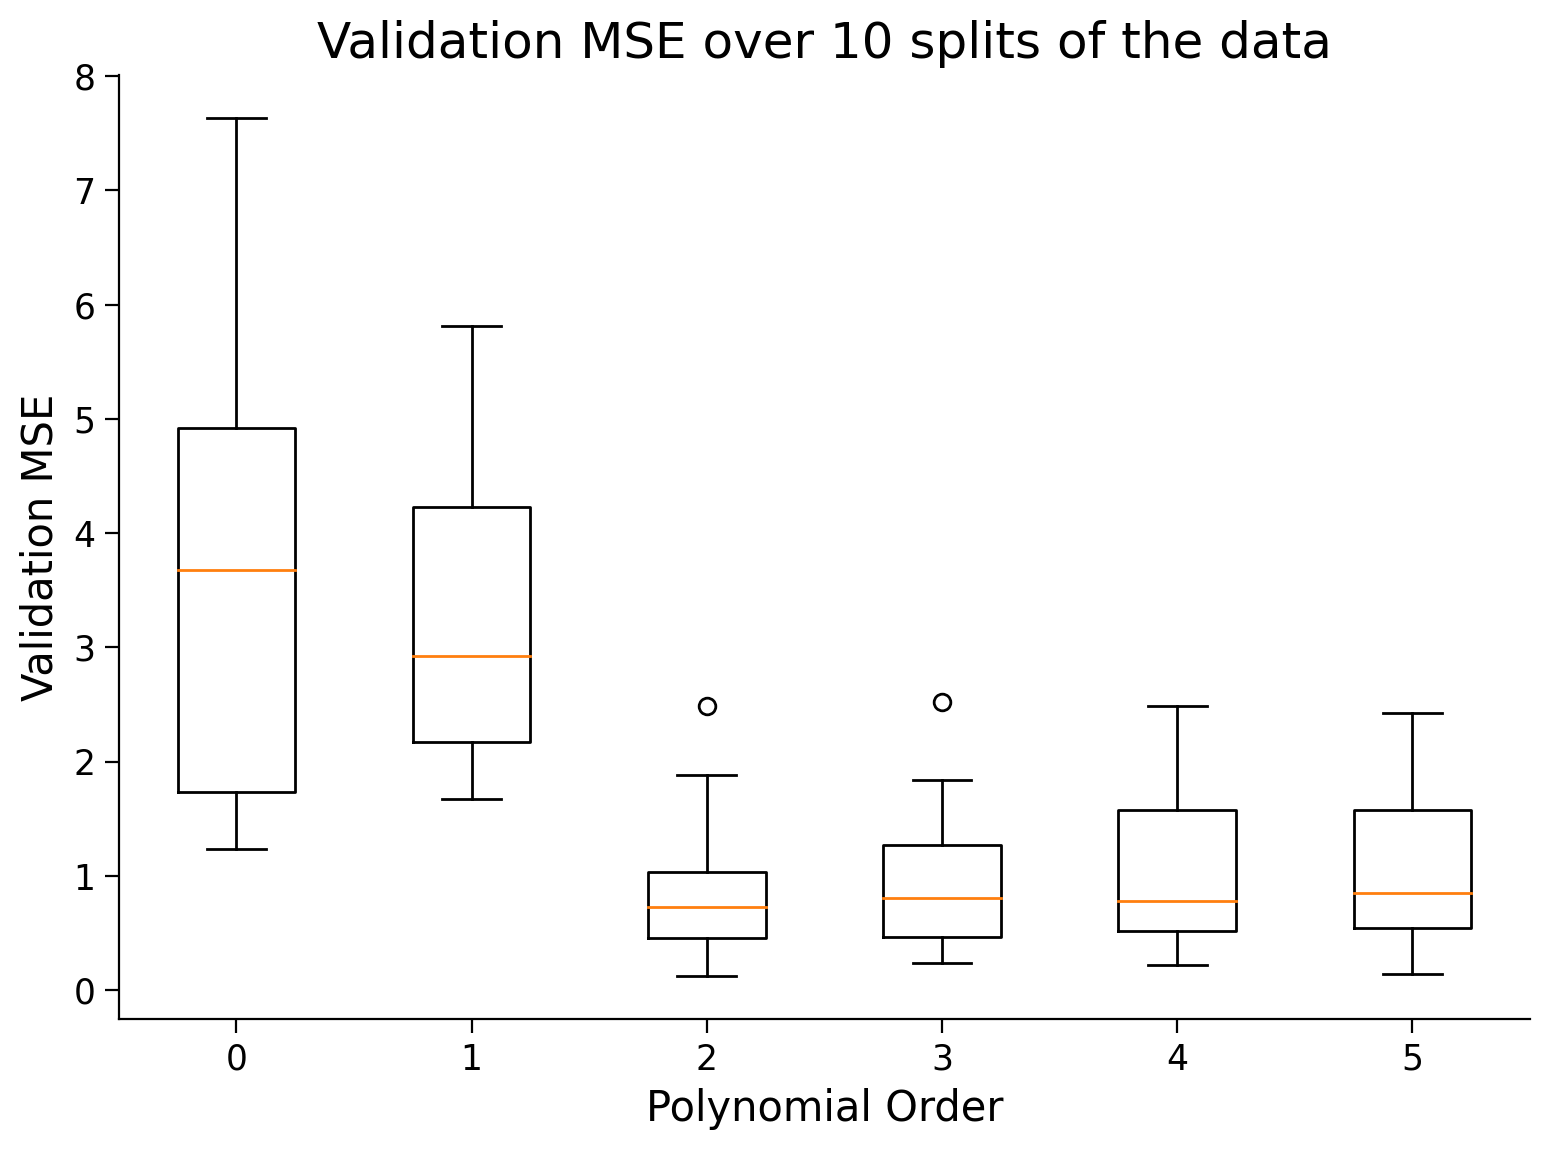

In [18]:
def cross_validate(x_train, y_train, max_order, n_splits):
  """ Compute MSE for k-fold validation for each order polynomial

  Args:
    x_train (ndarray): training data input vector of shape (n_samples)
    y_train (ndarray): training vector of measurements of shape (n_samples)
    max_order (scalar): max order of polynomial fit
    n_split (scalar): number of folds for k-fold validation

  Return:
    ndarray: MSE over splits for each model order, shape (n_splits, max_order + 1)

  """

  # Initialize the split method
  kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  mse_all = np.zeros((n_splits, max_order + 1))

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(x_train)):

      # Split up the overall training data into cross-validation training and validation sets
      x_cv_train = x_train[train_indices]
      y_cv_train = y_train[train_indices]
      x_cv_val = x_train[val_indices]
      y_cv_val = y_train[val_indices]

      #############################################################################
      ## TODO for students: Fill in missing ... in code below to choose which data
      ## to fit to and compute MSE for
      # Fill out function and remove
      #raise NotImplementedError("Student exercise: implement cross-validation")
      #############################################################################

      # Fit models
      theta_hats = solve_poly_reg(x_cv_train, y_cv_train, max_order)

      # Compute MSE
      mse_this_split = evaluate_poly_reg( x_cv_val, y_cv_val, theta_hats, max_order)

      mse_all[i_split] = mse_this_split

  return mse_all


# Cross-validate
max_order = 5
n_splits = 10
mse_all = cross_validate(x_train, y_train, max_order, n_splits)

# Visualize
plot_cross_validate_MSE(mse_all)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D2_ModelFitting/solutions/W1D2_Tutorial6_Solution_ddce210a.py)



Which polynomial order do you think is a better model of the data?

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Implement_Cross_Validation_Exercise")

---
# Summary

*Estimated timing of tutorial: 25 minutes*

We need to use model selection methods to determine the best model to use for a given problem.

Cross-validation focuses on how well the model predicts new data.

---
# Bonus

## Bonus Section 1: Akaike's Information Criterion (AIC)

In order to choose the best model for a given problem, we can ask how likely the data is under a given model. We want to choose a model that assigns high probability to the data. A commonly used method for model selection that uses this approach is **Akaike’s Information Criterion (AIC)**.

Essentially, AIC estimates how much information would be lost if the model predictions were used instead of the true data (the relative information value of the model). We compute the AIC for each model and choose the model with the lowest AIC. Note that AIC only tells us relative qualities, not absolute - we do not know from AIC how good our model is independent of others.

AIC strives for a good tradeoff between overfitting and underfitting by taking into account the complexity of the model and the information lost. AIC is calculated as:

\begin{equation}
\mathrm{AIC} = 2K - 2 \log(\mathcal{L})
\end{equation}

where $K$ is the number of parameters in your model and $\mathcal{L}$ is the likelihood that the model could have produced the output data.

Now we know what AIC is, we want to use it to pick between our polynomial regression models. We haven't been thinking in terms of likelihoods though - so how will we calculate $\mathcal{L}$?

As we saw in Tutorial 2, there is a link between mean squared error and the likelihood estimates for linear regression models that we can take advantage of.

*Derivation time!*

We start with our formula for AIC from above:

\begin{equation}
\mathrm{AIC} = 2k - 2 \log \mathcal{L}
\end{equation}

For a model with normal errors, we can use the log likelihood of the normal distribution:

\begin{equation}
\log \mathcal{L} = -\frac{n}{2} \log(2 \pi) -\frac{n}{2}\log(\sigma^2) - \sum_i^N \frac{1}{2 \sigma^2} (y_i - \tilde y_i)^2
\end{equation}

We can drop the first as it is a constant and we're only assessing relative information with AIC. The last term is actually also a constant: we don't know $\sigma^2$ in advance so we use the empirical estimate from the residual ($\hat{\sigma}^2 = 1/N\sum_i^N (y_i - \tilde y_i)^2$). Once we plug this in, the two $\sum [(y - \tilde y)^2]$ terms (in the numerator and denominator, respectively) cancel out and we are left with the last term as $\frac N 2$.

Once we drop the constant terms and incorporate into the AIC formula we get:

\begin{equation}
\mathrm{AIC} = 2k + n\log \left( \sigma^2 \right)
\end{equation}

We can replace $\sigma^2$ with the computation for variance (the sum of squared errors divided by number of samples). Thus, we end up with the following formula for AIC for linear and polynomial regression:

\begin{equation}
\mathrm{AIC} = 2K + n \log \left( \frac{\mathrm{SSE}}{n} \right)
\end{equation}

where $k$ is the number of parameters, $n$ is the number of samples, and $\mathrm{SSE}$ is the summed squared error.

### Bonus Exercise 1: Compute AIC

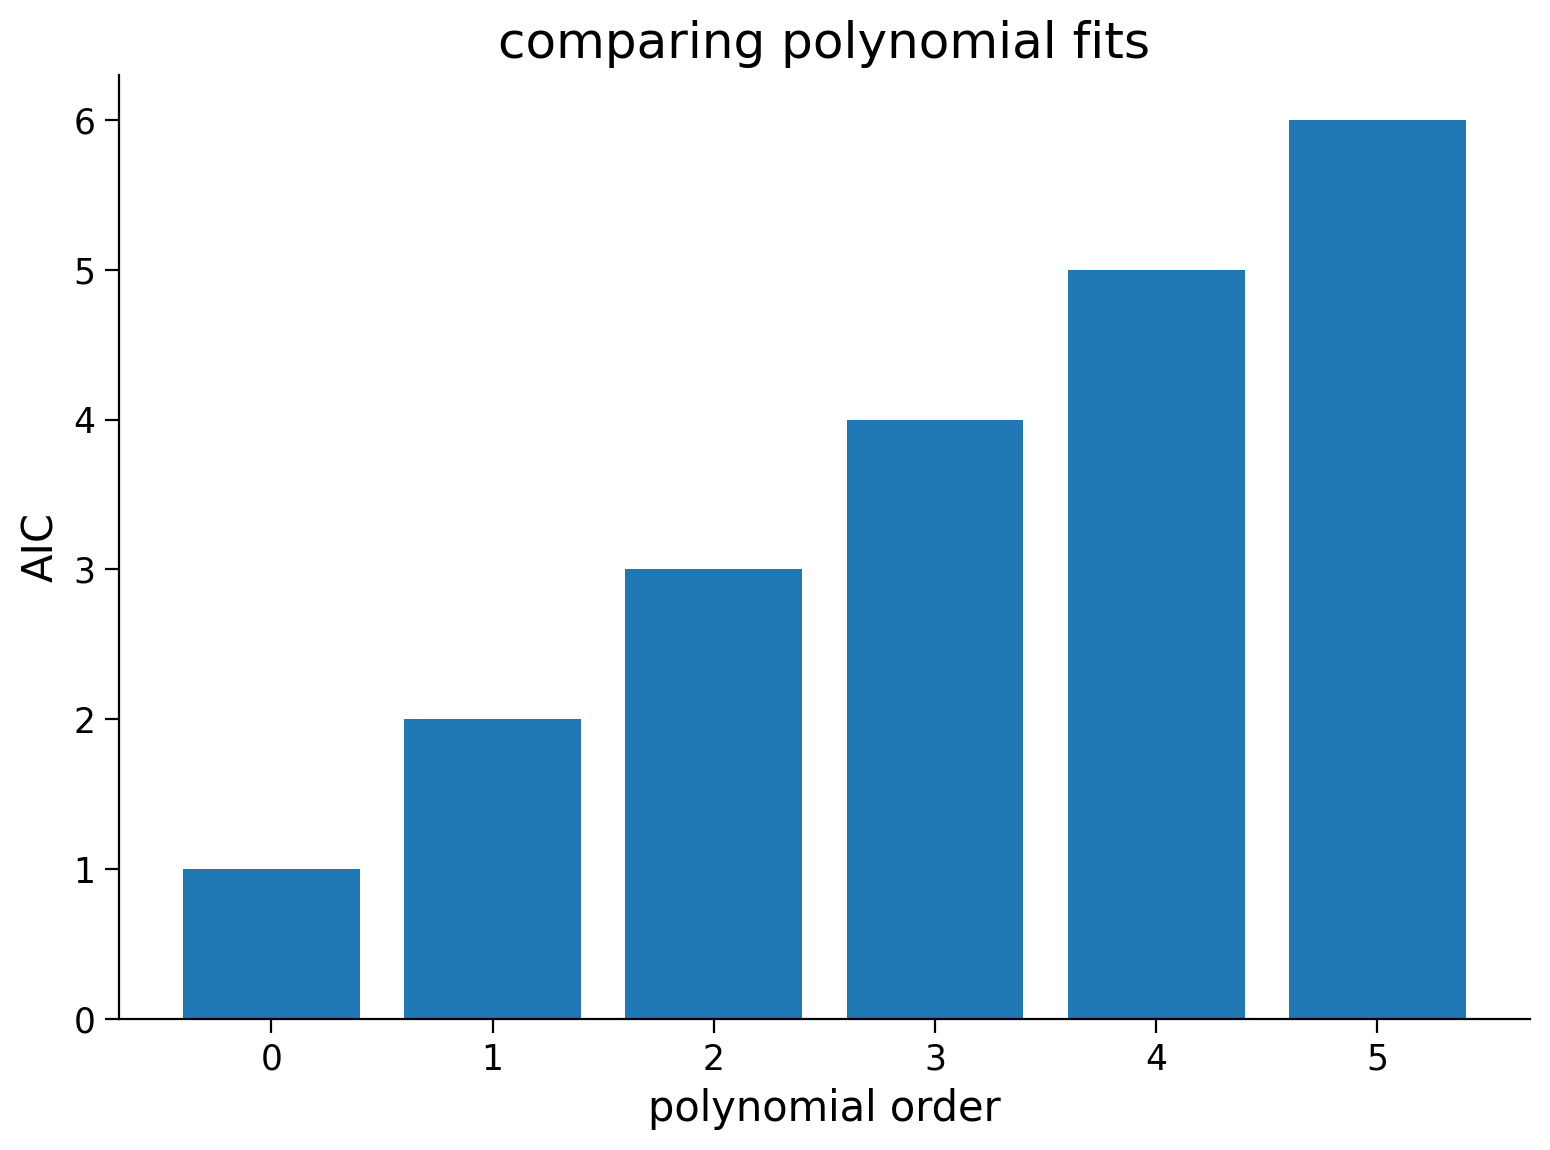

In [20]:
AIC_list = []
order_list = list(range(max_order + 1))

for order in order_list:

  # Compute predictions for this model
  X_design = make_design_matrix(x_train, order)
  y_hat = np.dot(X_design, theta_hats[order])

  #############################################################################
  ## TODO for students:
  ## to fit to and compute MSE for
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: implement compute AIC")
  # 1) Compute sum of squared errors (SSE) given prediction y_hat and y_train
  # 2) Identify number of parameters in this model (K in formula above)
  # 3) Compute AIC (call this_AIC) according to formula above
  #############################################################################

  # Compute SSE
  residuals =  y_train - y_hat
  sse = np.sum(residuals ** 2)

  # Get K
  K = len(theta_hats[order])

  # Compute AIC
  AIC = len(theta_hats[order])

  AIC_list.append(AIC)

# Visualize
plt.bar(order_list, AIC_list)

plt.ylabel('AIC')
plt.xlabel('polynomial order')
plt.title('comparing polynomial fits')
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D2_ModelFitting/solutions/W1D2_Tutorial6_Solution_16748857.py)



Which model would we choose based on AIC?

In [21]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Compute_AIC_Bonus_Exercise")